In [1]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold
using JLD2

# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [2]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases
#H = deepcopy(new_H) # log(H)
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases

@assert length(materials) == nm && length(gases) == ng

In [3]:
sum(ismissing.(H))/length(H)

0.9044608901223147

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [4]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2}, 
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) <= sum(ismissing.(H[:, 3])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) <= sum(ismissing.(H[3, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [5]:
# nm = 20
# ng = 10

# H = H[1:nm, 1:ng]
# materials = materials[1:nm]
# gases = gases[1:ng];

# sort_rows_cols_acc_to_nb_obs!(H, materials, gases)
# println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
# println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# # TODO copy Arni's code for viz of frequency of observations gases and mofs

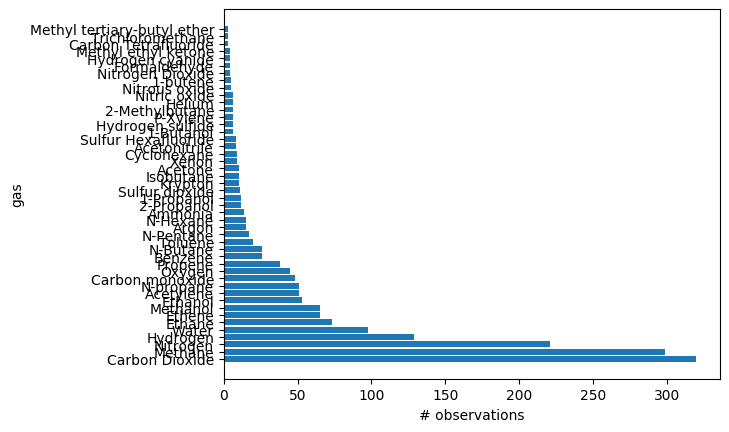

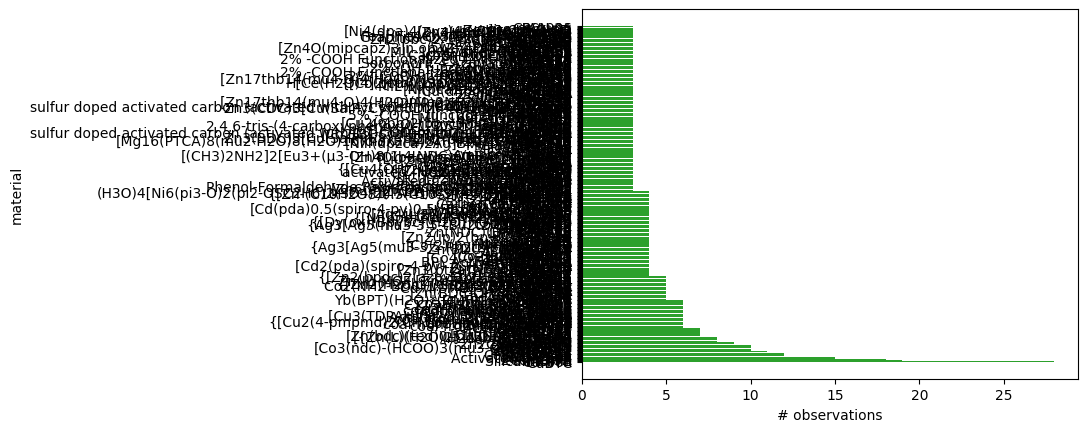

PyObject Text(24.0000000000001, 0.5, 'material')

In [6]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## standardize columns
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [7]:
# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end
# Udell ?: does it make sense to normalizes gases but not MOFs? 
#  Cory's justification: gases exhibit tons of variance in the means

In [8]:
H

423×46 Array{Union{Missing, Float64},2}:
  0.392255    0.199608     0.0872181  …  0.487208  -0.968068    missing
 -0.142494   -0.104007     0.111342       missing    missing    missing
 -0.366531   -0.205451    -0.101137       missing    missing    missing
   missing    0.246834     0.132064       missing  -0.0610661  0.632379
  2.3692      0.252586     0.372746       missing    missing    missing
 -0.870799   -0.381353    -0.511134   …   missing    missing    missing
  0.251402    0.319248     0.146624       missing    missing    missing
  1.66332     0.361303     0.888013       missing    missing    missing
 -0.364954   -0.202188    -0.1653         missing    missing    missing
 -0.0308691  -0.00666754  -0.119214       missing    missing    missing
 -0.499997   -1.17874     -0.261      …   missing    missing    missing
 -1.98216    -2.007         missing       missing    missing    missing
  1.93194     0.454506     0.831141       missing    missing    missing
  ⋮                    

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

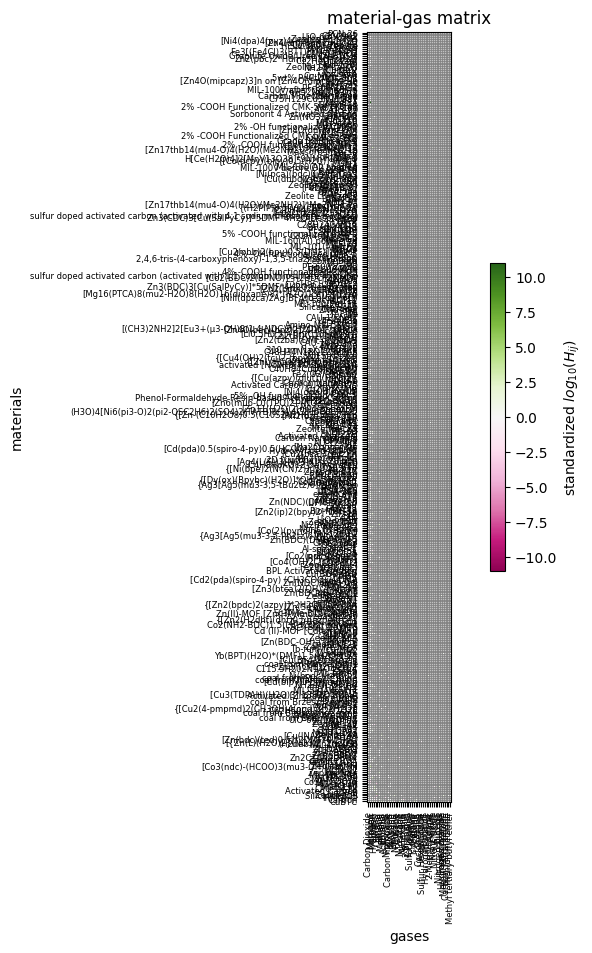

In [9]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

spy_H2 = fill(0.0, size(H))
spy_H2[.!ismissing.(H)] .= 0
spy_H2[ismissing.(H)] .= 1

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)

#cmap = plt.get_cmap("PiYG")
#colors = cmap(collect(1:cmap.N))
colors = Array{Float64, 2}(undef, 2, 4)
colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
colors[2, :] .= [192., 192., 192., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)
img = ax.pcolormesh(spy_H2, cmap=cmap)

# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
ax.set_title("material-gas matrix")
ax.set_xlabel("gases")
ax.set_ylabel("materials")
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90, fontsize=6)
yticks(collect(1:nm) .- 0.5, materials, fontsize=6);

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [10]:
H = collect(H')

46×423 Array{Union{Missing, Float64},2}:
  0.392255   -0.142494   -0.366531  …   0.458087    missing  0.616238
  0.199608   -0.104007   -0.205451     -0.673232    missing  0.470805
  0.0872181   0.111342   -0.101137      0.583271    missing  0.596021
 -0.196112   -0.0436679  -0.329756       missing    missing   missing
  0.863554   -0.930879   -1.78449        missing  -3.52526    missing
 -0.469602   -0.24981    -0.34903   …    missing    missing   missing
  0.801065    0.483842     missing       missing    missing   missing
  1.13289     0.687745     missing       missing   1.11697    missing
  1.23019      missing     missing       missing    missing   missing
  0.470855     missing   -0.616612       missing    missing   missing
  0.0762907    missing   -1.79638   …    missing    missing   missing
  0.713886    0.26057    -0.140543       missing    missing   missing
  0.35142     0.134267     missing       missing    missing   missing
  ⋮                                 ⋱   ⋮        

# find the optimal low rank model through cross-validation

In [11]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 1859
fraction entries that are filled = 0.09553910987768527


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [12]:
# k = rank of matrix
# γ = regularization param
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64},1}; verbose::Bool=true)
    rg = QuadReg(γ) # quadratic regularizer on X, Y
    rm = QuadReg(γ * ng / nm)

    glrm = GLRM(H, QuadLoss(), rg, rm, k, obs=obs, offset=true)

    G, M, ch = fit!(glrm, ProxGradParams(max_iter=1000), verbose=verbose) # H' ~ G' * M well, our mathy H

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

G, M, glrm, ch = fit_glrm(1, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 891.6837012386783


([1.0 1.0 … 1.0 1.0], [0.49030268342346567 0.004543157351111568 … -0.9607067570390383 0.5602460592586499], GLRM(Union{Missing, Float64}[0.3922546560568413 -0.14249441875112578 … missing 0.6162380593898769; 0.19960779112475782 -0.10400708701883891 … missing 0.47080520992279384; … ; -0.9680675499104198 missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(30.0)), lastent

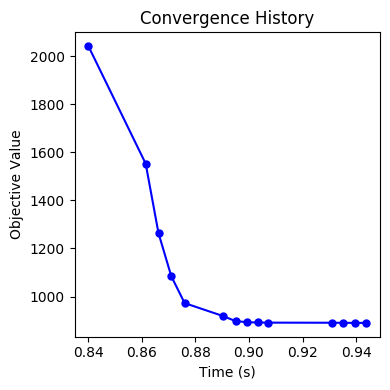

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [14]:
function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000)
    #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
    @printf("Splitting matrix into %d folds\n", k)

    fold_matrix = fill(0, size(H))
    all_k_folds_not_represented_in_each_column = true
    n_iteration = 0

    while all_k_folds_not_represented_in_each_column
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = false
        for j_col = 1:size(H)[2]
            # Grabs all available indices in row `i_row`
            i_indices = findall(.!ismissing.(H[:,j_col]))
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while length(i_indices) >= k
                for fold = 1:k
                    i = rand(1:length(i_indices))
                    fold_matrix[i_indices[i], j_col] = fold
                    deleteat!(i_indices, i)
                end
            end
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for i in i_indices
                items = collect(1:k)
                weights = [sum(fold_matrix[:, j_col] .!= _k .| fold_matrix[:, j_col] .!= 0) for _k = 1:k]
                fold_matrix[i, j_col] = sample(items, Weights(weights))
                #fold_matrix[i, j_col] = rand(1:k)
            end
        end
        # We make sure we have enough data points in the columns as well
        for i_row = 1:size(H)[1]
            unique_folds = unique(fold_matrix[i_row, :])
            if length(unique_folds) <= k
                all_k_folds_not_represented_in_each_column = true
                break
            end
        end

        # If too many iteration are performed an Exception is raised.
        if n_iteration >= max_iter
            error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
        end
    end
    
    for i = 1:size(H)[1]
        for j = 1:size(H)[2]
            if ismissing(H[i,j])
                continue
            else
                @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
            end
        end
    end
    
    @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
    for fold = 1:k
        @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
    end
    @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
    @printf("-----------------------------------\n")
    return fold_matrix
end

fold_matrix = k_fold_split(H, 3, max_iter=100000)
temp_fold_matrix = replace(fold_matrix, 0 => missing)
kfolds = [(findall(collect(skipmissing(temp_fold_matrix))[:] .!= k), 
           findall(collect(skipmissing(temp_fold_matrix))[:] .== k)) 
                for k = 1:length(unique(fold_matrix))-1]
n_folds = length(kfolds)

Splitting matrix into 3 folds
Number of iterations required to split data into 3-folds: 40332
Number of data points in fold 1: 615
Number of data points in fold 2: 622
Number of data points in fold 3: 622
Total number of data points: 1859
-----------------------------------


3

In [15]:
#n_folds = nb_obs # K-fold cross validation
#println("running $n_folds-cross validation...")
#kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

visualize the fold matrix

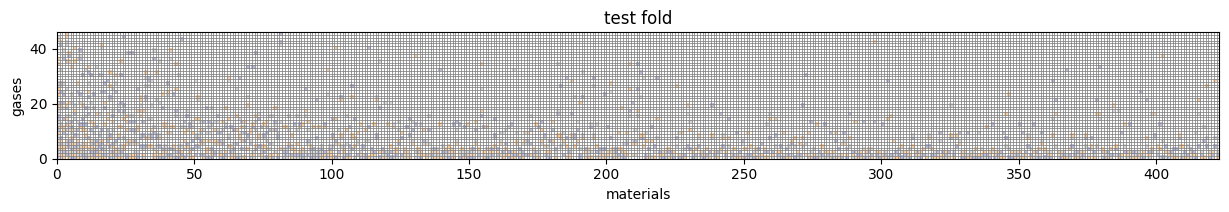

In [16]:
test_fold_matrix = Int.(zeros(size(H)))
for (i, fold) in enumerate(kfolds)
    for ix in fold[2]
        test_fold_matrix[ids_obs[ix][1], ids_obs[ix][2]] = i
    end
end

cmap = plt.get_cmap("tab20c")
colors = cmap(collect(1:cmap.N))
#colors = Array{Float64, 2}(undef, 6, 4)
colors[1, :] .= [0.0, 0.0, 0.0, 0.0] ./ 255
# colors[2, :] .= [128., 0., 0., 255.] ./ 255
# colors[3, :] .= [170., 255., 195., 255.] ./ 255
# colors[4, :] .= [145., 30., 180., 255.] ./ 255
# colors[5, :] .= [255., 250., 200., 255.] ./ 255
# colors[6, :] .= [0., 130., 200., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)



fig, ax = plt.subplots(figsize=(15, 15))
ax.pcolormesh(test_fold_matrix, cmap=cmap)

# grid lines
for x = 1:size(test_fold_matrix)[1]
    plot([0, size(test_fold_matrix)[2]], [x, x], linewidth=0.55, color="gray")
end
for y = 1:size(test_fold_matrix)[2]
    plot([y, y ], [0, size(test_fold_matrix)[1]], linewidth=0.55, color="gray")
end


ax.set_aspect("equal")
ax.set_xlabel("materials")
ax.set_ylabel("gases")
ax.set_title("test fold")
#ax.set_xlabel("Fold Frequency")
# TODO put legend in there for the fold
plt.show()

## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [31]:
ks = [1,2,3] # ranks
γs = 10.0 .^ range(1.0, 5.0, length=50); # regularization params

map rank to color for data visualizations

In [32]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7f4257a137b8>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [33]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            G, M, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)
            
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

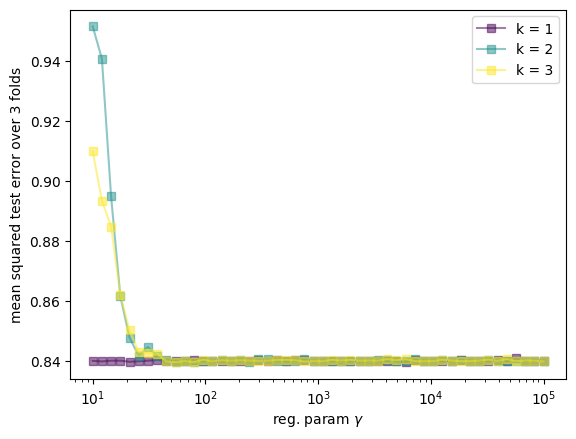

PyObject <matplotlib.legend.Legend object at 0x7f42579914e0>

In [34]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean squared test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label=@sprintf("k = %d", k), marker="s", color=rank_to_color(k), alpha=0.5)
end
xscale("log")
legend()
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

## work with optimal model

In [35]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@show(min_mse)
@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

min_mse = [0.8395063036295012, 0.8396651019485902, 0.8396016714882503]
optimum γ = 5963.623, optimum k = 1


### parity plot over `n_folds`-cross validation

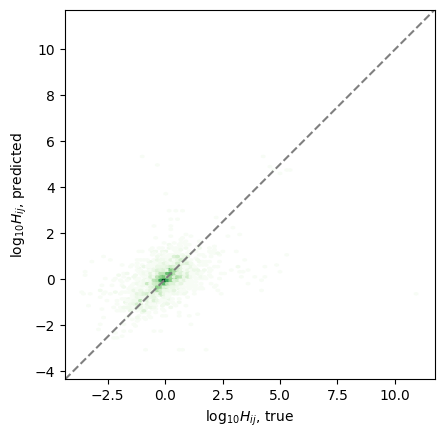

this_mse = 0.8372338445637251
R² = 0.13829103477335303
Numerator: 1562.278
Denomirator: 1813.000


In [36]:
H_actual = Float64[]
H_pred = Float64[]
this_mse = 0.0
for (train_ids, test_ids) in kfolds
    # train model on training data
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
    this_mse = sum((H_pred .- H_actual) .^ 2) / length(test_ids)
end

this_mse /= n_folds
@show(this_mse)

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²
@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))


fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
#scatter(H_actual, H_pred, s=3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, linestyle="--", color="gray")
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect("equal")


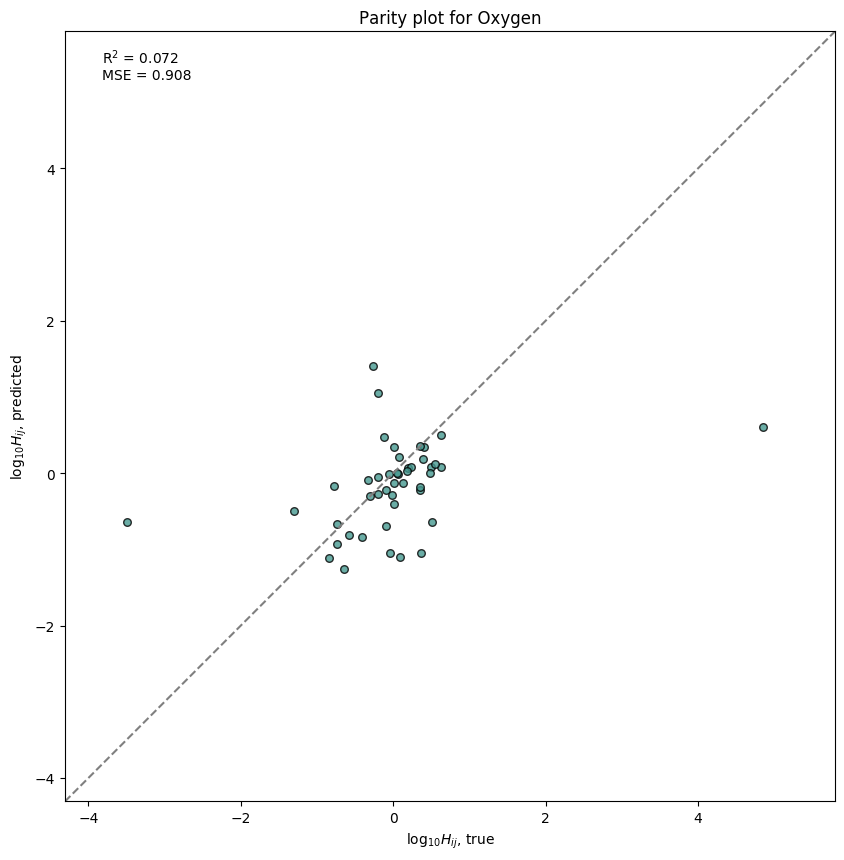

R² = 0.07158137842812906
Numerator: 40.850
Denomirator: 44.000


In [95]:
function gas_parity_plot(gas::Union{Int, AbstractString})
    if typeof(gas) <: AbstractString
        @assert gas in gases
        gas = findfirst(gas .== gases)
    end
    H_actual = Array{Float64, 1}()
    H_pred = Array{Float64, 1}()
    rmses = Array{Float64, 1}()
    for (train_ids, test_ids) in kfolds
        # train model on training data
        G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)

        # test
        Ĥ = impute(glrm)
        H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
        H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
        this_mse = sum((H_pred .- H_actual) .^ 2) / length(H_pred)
    end

    R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
    @show R²
    @printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
    @printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))


    fig, ax = subplots(figsize=(10,10))
    ax.set_xlabel(L"$\log_{10} H_{ij}$, true")
    ax.set_ylabel(L"$\log_{10} H_{ij}$, predicted")
    if length(H_pred) > 80
        ax.hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
    else
        ax.scatter(H_actual, H_pred, s=30, fc="#469990", ec="k", alpha=0.8)
    end
    xlim = [ax.get_xlim()...]
    ylim = [ax.get_ylim()...]
    
    lim = diff(xlim)[1] > diff(ylim)[1] ? xlim : ylim
    ax.plot(lim.*1.1, lim.*1.1, linestyle="--", color="gray")
    ax.set_xlim(lim.*1.1)
    ax.set_ylim(lim.*1.1)
    ax.text(lim[1]+0.1, lim[2]-0.1, @sprintf("R\$^2\$ = %.3f\nMSE = %.3f", R², sum((H_pred .- H_actual) .^ 2)/length(H_pred)))

    ax.set_title("Parity plot for " * gases[gas])
    ax.set_aspect("equal")
end
gas_parity_plot(13)

In [79]:
H[11,:]

423-element Array{Union{Missing, Float64},1}:
  0.0762906872160516 
   missing           
 -1.7963785571687638 
  0.4642181089750542 
  0.604457505379906  
 -0.1849144907890512 
  0.17629892182088064
  0.38091274248425855
   missing           
 -0.1632209044478245 
 -2.860643225764901  
   missing           
  0.5640071729825823 
  ⋮                  
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           
   missing           

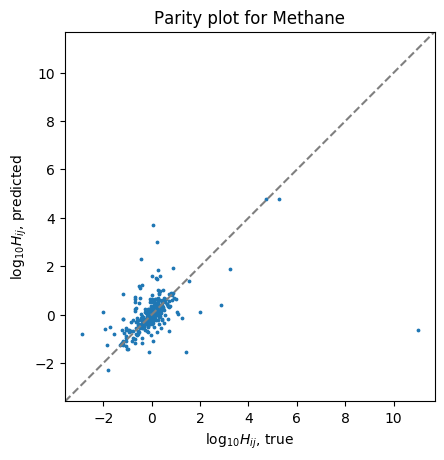

R² = 0.10708764164480233
Numerator: 266.088
Denomirator: 298.000


In [38]:
H_actual = Array{Float64, 1}()
H_pred = Array{Float64, 1}()
this_mse = 0.0
gas = 2
for (train_ids, test_ids) in kfolds
    # train model on training data
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
    #this_mse = sum((H_pred .- H_actual) .^ 2) / length(H_pred)
end

#this_mse /= n_folds
#@show(this_mse)

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²
@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))


fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
#hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
scatter(H_actual, H_pred, s=3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, linestyle="--", color="gray")
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_title("Parity plot for " * gases[gas])
ax.set_aspect("equal")


In [39]:
H_actual = convert(Array{Float64, 1}, H_actual)
H_pred = convert(Array{Float64, 1}, H_pred)

299-element Array{Float64,1}:
 -0.018428807715635494
 -0.29517307185111946 
 -0.9662100561565243  
  0.8353829334097652  
  0.12964912399534662 
 -0.07793331442101761 
 -0.04542798144321091 
  0.5197738437641019  
  0.20184754793432433 
 -0.1270293840521579  
  0.2193653747984288  
  0.8045340102993752  
  1.1209110019298552  
  ⋮                   
 -0.549122334184439   
 -0.04423794263468341 
 -1.1525533786318776  
 -0.6669112310013324  
 -0.2033409569176668  
  0.3581934032514757  
  0.553235506267025   
  0.09074203235529582 
  0.051938967462342195
 -0.33202965402955875 
  0.4913644887029406  
  0.45880440532982597 

In [40]:
spearman_correlation_coeff = corspearman(H_actual, H_pred)

0.5969239747704878

In [41]:
mean(H_actual)

-3.156152411141749e-17

## viz offsets and latent space on fully trained model

In [42]:
G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

([1.0 1.0 … 1.0 1.0], [0.4930539730490982 0.0024755642359228737 … -0.9564942034164857 0.5597221072187512], GLRM(Union{Missing, Float64}[0.3922546560568413 -0.14249441875112578 … missing 0.6162380593898769; 0.19960779112475782 -0.10400708701883891 … missing 0.47080520992279384; … ; -0.9680675499104198 missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(5963.6233165946

### offsets $\mu_i$ representing material biases

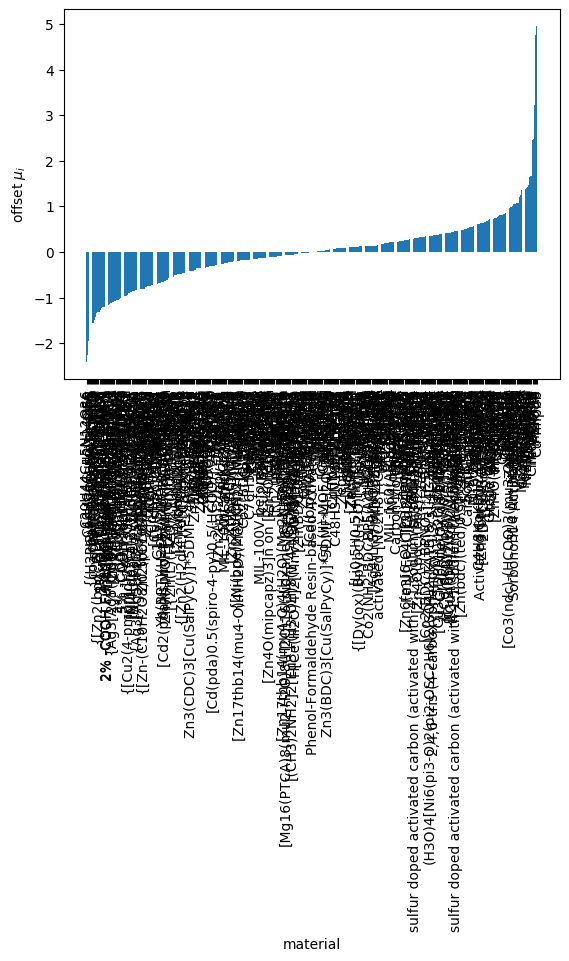

In [43]:
μ = M[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

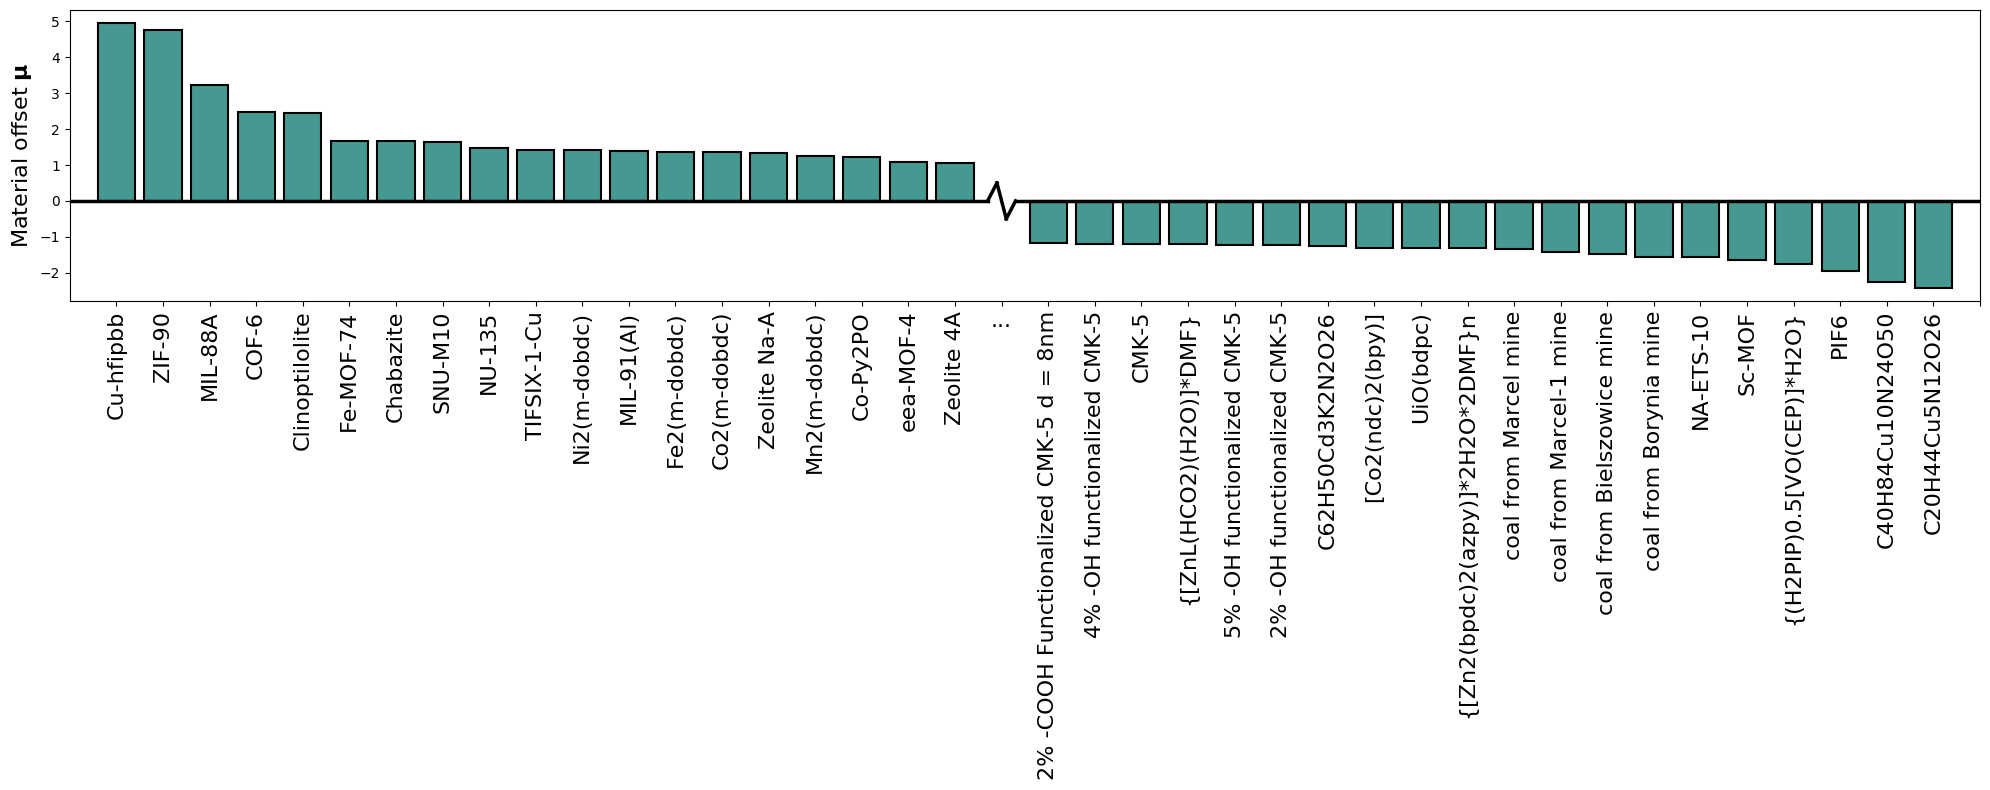

In [44]:
function plot_offset(μ::Array{Float64, 1}, show_all_materials=false)
    N = length(μ)
    sorted_idx = sortperm(μ)[end:-1:1]
    color = "#469990"
    edgecolor = "k"
    if N > 40 && !show_all_materials
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:19, μ[sorted_idx][1:19], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.bar(21:40, μ[sorted_idx][end-19:end], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.plot([-1, 19.7], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([20.3, 41], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([19.7, 19.9], [0, 0.5], c=edgecolor, lw=2.5)
        ax.plot([19.9, 20.1], [0.5, -0.5], c=edgecolor, lw=2.5)
        ax.plot([20.1, 20.3], [-0.5, 0], c=edgecolor, lw=2.5)
        ax.set_xlim(0, 41)
    else
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:N, μ[sorted_idx], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0, 0], c=edgecolor, lw=3.5, alpha=0.5)
        ax.set_xlim(0, N)
    end
    
    
    ax.set_ylabel(L"Material offset $\mathbf{\mu}$", fontsize=16)
    xlabels = [material for material in materials[sorted_idx]]
    if N > 40 && !show_all_materials
        ax.set_xticks(1:41)
            ax.set_xticklabels(vcat(vcat(xlabels[1:19], ["..."]), xlabels[end-19:end]), rotation=90, fontsize=16)
        for tick in ax.get_xticklabels()
            if tick.get_text() == "..."
                tick.set_rotation(0)
            end
        end
    else
        ax.set_xticks(1:length(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=16)
    end
    #ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.tight_layout()
    #plt.savefig('pics/' + mof_or_gas + '_biases_plot.pdf', format='pdf', dpi=300)
    plt.show()
end
asdf = plot_offset(μ, false)

### latent space of materials